---
<img src="https://drive.google.com/uc?export=view&id=1HGhzW9yEcMRYy0S88PyzhKcHiizFcNIi" height="450" width="10000"/>

---


# Voice Activity Detection (VAD)

Voice Activity Detection (VAD) is a technique used to determine the presence or absence of human speech in an audio signal. It is a crucial component in speech processing systems, improving the efficiency of applications such as speech recognition, audio compression, and telecommunications.

## Overview
VAD helps in distinguishing between speech and non-speech segments in an audio stream. By identifying the presence of speech, VAD reduces unnecessary processing of non-speech parts, optimizing the performance of speech-related systems.

### Key Features
- Detects speech segments in real-time or batch audio processing.
- Uses energy-based and machine learning techniques for speech classification.
- Works effectively even in noisy environments.

## How VAD Works
VAD algorithms analyze various features of an audio signal to determine the presence of speech:
1. **Energy-Based Methods**: This technique uses the energy levels of the audio signal to detect speech. A high energy value typically indicates speech, while lower energy values correspond to silence or background noise.
2. **Zero-Crossing Rate (ZCR)**: This method counts how often the signal amplitude crosses zero, which can be used to distinguish speech from non-speech segments.
3. **Machine Learning Model**: In some advanced systems, VAD is performed using trained models, such as neural networks, which classify audio segments as speech or non-speech based on learned patterns.

## Applications
- **Speech Recognition**: Focuses the speech recognition process on speech segments, improving performance and accuracy.
- **Telecommunications**: Reduces bandwidth usage by only transmitting segments that contain speech.
- **Audio Compression**: Helps reduce file sizes by ignoring non-speech sections of an audio recording.
- **Hearing Aids**: Improves real-time audio processing for better understanding of speech in noisy environments.

## Setup and Installation

To install and run the VAD system, follow these steps:

1. Clone the repository:

   ```bash
   git clone https://github.com/AyushPoojariUCD/Voice-Activity-Detection.git
   ```

2. Create virtual enviroment

  ```bash
  python -m venv venv
  ```

3. Run streamlit application using command:

  ```bash
  streamlit run app.py
  ```

### 📌 Group Detail
### `Student Name: Ayush Poojari Student ID: 24214170`
### `Student Name: Sudhanshu Ghughe Student ID: 24213171`

In [29]:
!pip install librosa
!pip install whisper
!pip install numpy
!pip install scipy
!pip install matplotlib

### Importing Libraries

In [4]:
import librosa
import whisper
import numpy as np
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

### Voice Activity Detection (VAD Utilities)

In [5]:
import numpy as np

def _connect_energy_with_frequencies(data_window, sample_rate=16000):
    fft = np.fft.rfft(data_window)
    freqs = np.fft.rfftfreq(len(data_window), 1/sample_rate)
    power = np.abs(fft) ** 2
    return dict(zip(freqs, power))

def _sum_energy_in_band(energy_dict, start_band=300, end_band=3000):
    return sum(v for k, v in energy_dict.items() if start_band <= k <= end_band)

def _median_filter(x, k):
    assert k % 2 == 1
    assert x.ndim == 1
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = x[-1]
    return np.median(y, axis=1)

def _smooth_speech_detection(detected_voice, speech_window=0.5, window=0.02):
    median_window = int(speech_window / window)
    if median_window % 2 == 0:
        median_window -= 1
    detected_voice_array = np.array(detected_voice, dtype=int)
    return _median_filter(detected_voice_array, median_window)

def get_speech_segments(smoothed_voice, window_size=0.02):
    segments = []
    start = None
    for i, val in enumerate(smoothed_voice):
        if val and start is None:
            start = i
        elif not val and start is not None:
            segments.append((start * window_size, i * window_size))
            start = None
    if start is not None:
        segments.append((start * window_size, len(smoothed_voice) * window_size))
    return segments

#### Audio reading files

In [6]:
def read_wav(path):
    rate, data = wf.read(path)
    if len(data.shape) == 2:
        data = data.mean(axis=1)
    data = data.astype(np.float32)
    data /= np.max(np.abs(data))
    return rate, data

In [7]:
from google.colab import files

print("Upload a WAV file for analysis:")
uploaded = files.upload()
file_path = next(iter(uploaded.keys()))

rate, data = read_wav(file_path)

Upload a WAV file for analysis:


Saving test.wav to test.wav


### Frequentcy based Voice Activity Detection

In [8]:
SAMPLE_WINDOW = 0.02
SAMPLE_OVERLAP = 0.01
THRESHOLD = 0.6

detected_voice_energy = []
sample_start = 0

while sample_start < len(data) - int(SAMPLE_WINDOW * rate):
    start_idx = int(sample_start)
    end_idx = start_idx + int(SAMPLE_WINDOW * rate)
    window = data[start_idx:end_idx]

    freq_energy = _connect_energy_with_frequencies(window, rate)
    total_energy = sum(freq_energy.values())
    voice_energy = _sum_energy_in_band(freq_energy)

    ratio = voice_energy / total_energy if total_energy > 0 else 0
    detected_voice_energy.append(ratio > THRESHOLD)

    sample_start += SAMPLE_OVERLAP * rate

smoothed = _smooth_speech_detection(detected_voice_energy, window=SAMPLE_WINDOW)
segments = get_speech_segments(smoothed, window_size=SAMPLE_WINDOW)

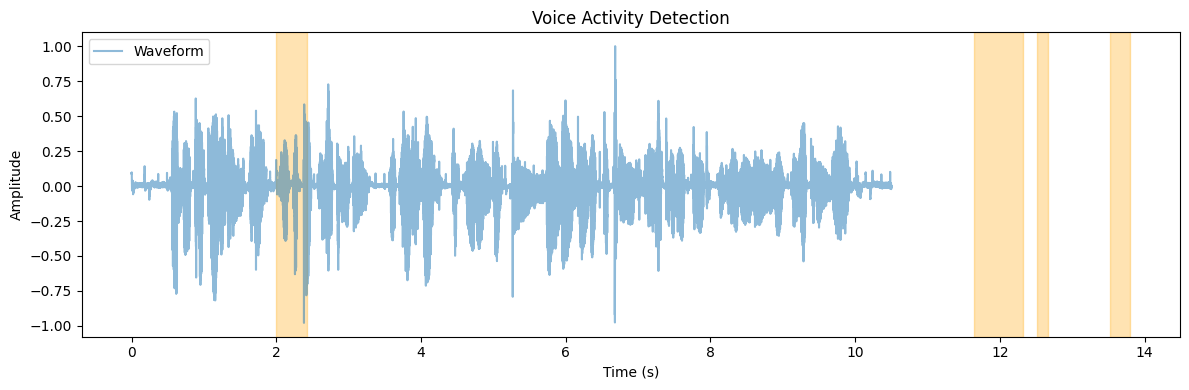

In [9]:
time = np.arange(len(data)) / rate
plt.figure(figsize=(12, 4))
plt.plot(time, data, alpha=0.5, label="Waveform")
for s, e in segments:
    plt.axvspan(s, e, color='orange', alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Voice Activity Detection")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Print Detected Segments
print("\nDetected Speech Segments:")
for i, (s, e) in enumerate(segments):
    print(f"Segment {i+1}: {s:.2f}s - {e:.2f}s")


Detected Speech Segments:
Segment 1: 2.00s - 2.42s
Segment 2: 11.64s - 12.32s
Segment 3: 12.52s - 12.66s
Segment 4: 13.52s - 13.80s


### Energy Based Voice Detection

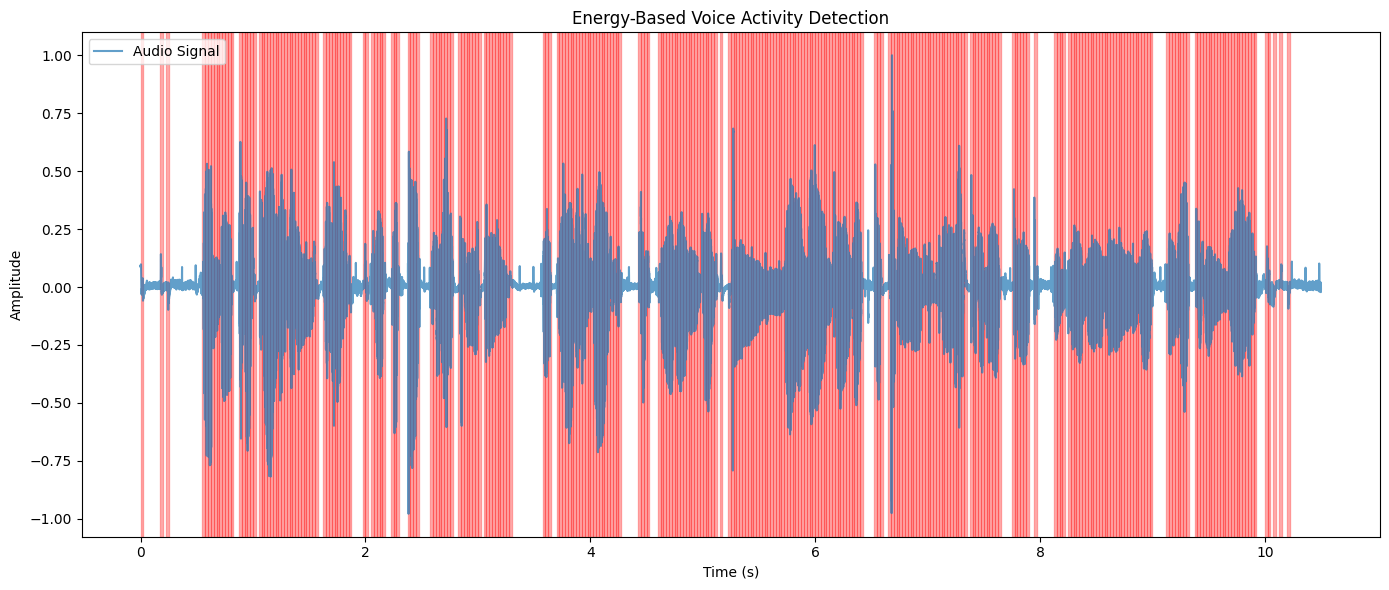

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def energy_vad(audio, rate, window_duration=0.025, threshold=0.01):
    frame_length = int(rate * window_duration)  # Frame size in samples
    num_frames = int(np.ceil(len(audio) / frame_length))

    vad_result = []

    for i in range(num_frames):
        start = i * frame_length
        end = start + frame_length
        frame = audio[start:end]
        energy = np.sum(frame**2)
        vad_result.append(1 if energy > threshold else 0)

    return vad_result

rate, audio = wavfile.read('test.wav')

if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

audio = audio / np.max(np.abs(audio))

# --- Run VAD ---
window_duration = 0.025  # 25ms
threshold = 0.4
vad_result = energy_vad(audio, rate, window_duration, threshold)

times = np.arange(len(audio)) / rate
frame_length = int(rate * window_duration)

plt.figure(figsize=(14, 6))
plt.plot(times, audio, label="Audio Signal", alpha=0.7)

for i, flag in enumerate(vad_result):
    if flag:
        start_time = i * window_duration
        end_time = (i + 1) * window_duration
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

plt.title("Energy-Based Voice Activity Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

### ZCR based Voice Detection

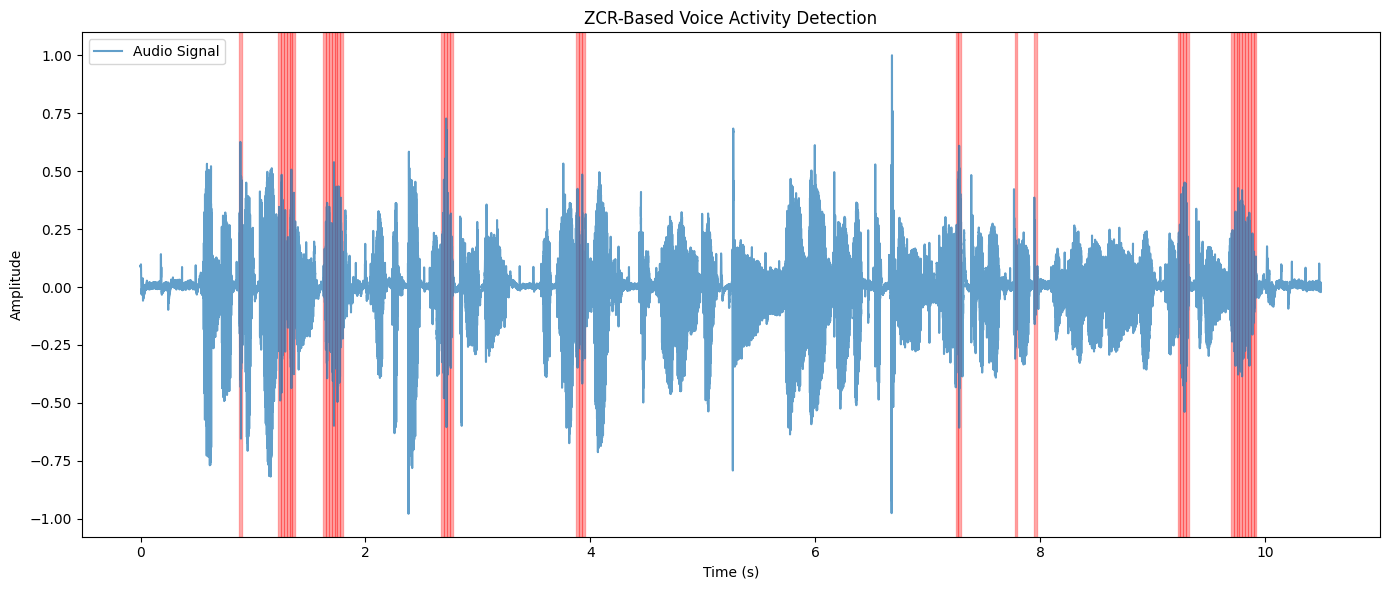

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# --- ZCR-based Voice Activity Detection ---
def zcr_vad(audio, rate, window_duration=0.025, threshold=0.02):
    frame_length = int(rate * window_duration)
    num_frames = int(np.ceil(len(audio) / frame_length))

    vad_result = []

    for i in range(num_frames):
        start = i * frame_length
        end = start + frame_length
        frame = audio[start:end]
        if len(frame) == 0:
            continue
        zcr = np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame))
        vad_result.append(1 if zcr > threshold else 0)

    return vad_result

rate, audio = wavfile.read('test.wav')  # Replace with your .wav file

if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

audio = audio / np.max(np.abs(audio))

window_duration = 0.025
threshold = 0.4
vad_result = zcr_vad(audio, rate, window_duration, threshold)

# --- Plot ---
times = np.arange(len(audio)) / rate
frame_length = int(rate * window_duration)

plt.figure(figsize=(14, 6))
plt.plot(times, audio, label="Audio Signal", alpha=0.7)

for i, flag in enumerate(vad_result):
    if flag:
        start_time = i * window_duration
        end_time = (i + 1) * window_duration
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

plt.title("ZCR-Based Voice Activity Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

### Spectral Entropy based Voice Activity Detection

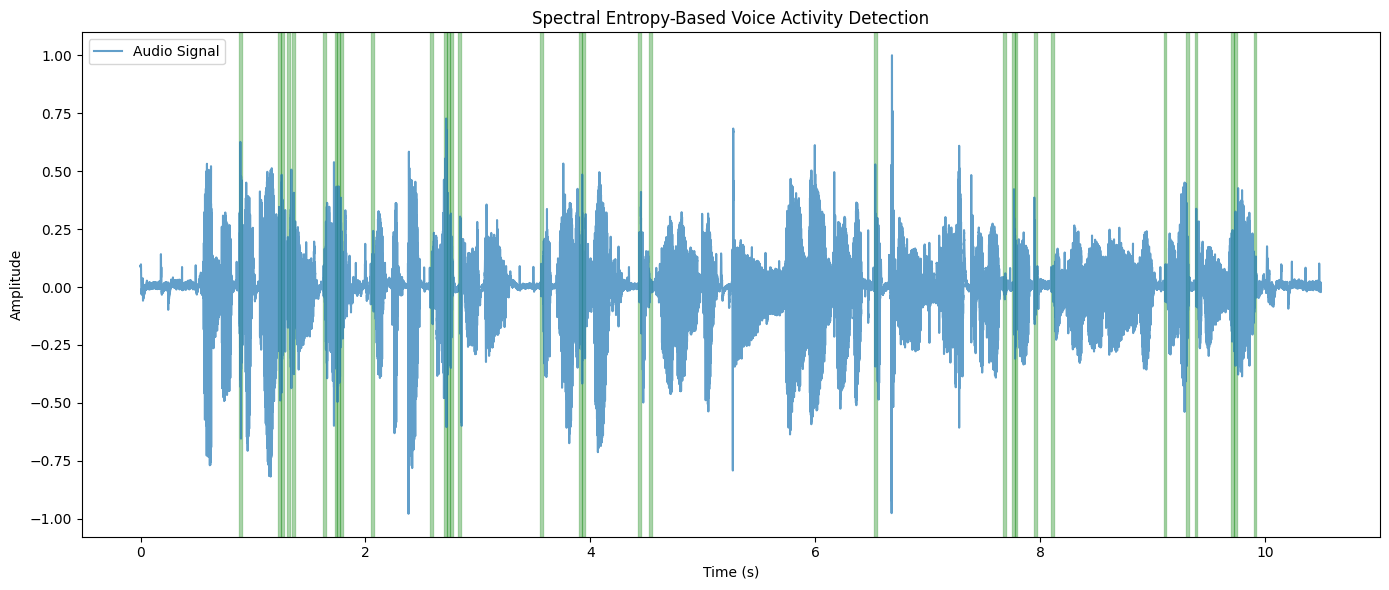

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import get_window
from scipy.fft import fft

# --- Spectral Entropy Calculation ---
def spectral_entropy(frame, eps=1e-8):
    spectrum = np.abs(fft(frame))[:len(frame)//2]
    psd = spectrum ** 2
    psd_norm = psd / (np.sum(psd) + eps)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + eps))
    return entropy / np.log2(len(psd_norm))  # Normalize to [0,1]

# --- Spectral Entropy VAD Function ---
def entropy_vad(audio, rate, window_duration=0.025, threshold=0.5):
    frame_length = int(rate * window_duration)
    num_frames = int(np.ceil(len(audio) / frame_length))
    window = get_window('hann', frame_length, fftbins=True)

    vad_result = []

    for i in range(num_frames):
        start = i * frame_length
        end = start + frame_length
        frame = audio[start:end]
        if len(frame) < frame_length:
            frame = np.pad(frame, (0, frame_length - len(frame)))
        frame = frame * window
        entropy = spectral_entropy(frame)
        vad_result.append(1 if entropy > threshold else 0)

    return vad_result

# --- Load and Preprocess Audio ---
rate, audio = wavfile.read('test.wav')

if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

audio = audio / np.max(np.abs(audio))

# --- Run VAD ---
window_duration = 0.025
threshold = 0.7  # Adjust based on dataset
vad_result = entropy_vad(audio, rate, window_duration, threshold)

# --- Plot ---
times = np.arange(len(audio)) / rate

plt.figure(figsize=(14, 6))
plt.plot(times, audio, label="Audio Signal", alpha=0.7)

for i, flag in enumerate(vad_result):
    if flag:
        start_time = i * window_duration
        end_time = (i + 1) * window_duration
        plt.axvspan(start_time, end_time, color='green', alpha=0.3)

plt.title("Spectral Entropy-Based Voice Activity Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


### Google's WebRTC Voice Activity Detection

In [27]:
!pip install webrtcvad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73511 sha256=6460ef8a667e7c0ec9b76987877383c6611eafd7cfba881fe8e7b7eed7d8bbb3
  Stored in directory: /root/.cache/pip/wheels/94/65/3f/292d0b656be33d1c801831201c74b5f68f41a2ae465ff2ee2f
Successfully built webrtcvad


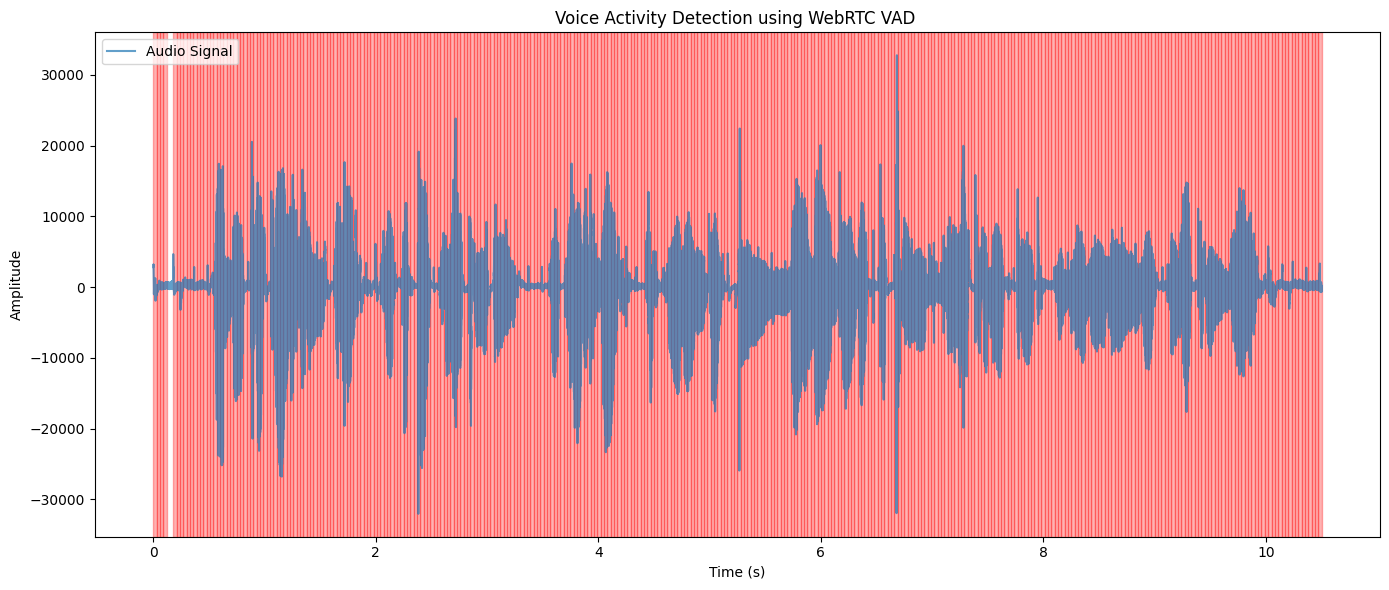

In [33]:
import webrtcvad
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Load audio (must be mono, 16-bit PCM, 16kHz)
rate, audio = wavfile.read('test.wav')
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1).astype(np.int16)

# Normalize to int16 range
audio = (audio / np.max(np.abs(audio)) * 32767).astype(np.int16)

# Initialize VAD with aggressiveness level
vad = webrtcvad.Vad(0)

frame_duration = 30  # in ms
frame_length = int(rate * frame_duration / 1000)
frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_length)]

# Run VAD
vad_flags = [vad.is_speech(frame.tobytes(), rate) for frame in frames if len(frame) == frame_length]

# Create time axis for plotting
times = np.arange(len(audio)) / rate

# Plotting the audio signal
plt.figure(figsize=(14, 6))
plt.plot(times, audio, label="Audio Signal", alpha=0.7)

# Plot speech regions (where VAD flag is 1)
for i, flag in enumerate(vad_flags):
    if flag:
        start_time = i * frame_duration / 1000
        end_time = (i + 1) * frame_duration / 1000
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

plt.title("Voice Activity Detection using WebRTC VAD ")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

### Voice Activity Detection using Silero VAD

In [39]:
!pip install torch torchaudio silero

In [44]:
!pip install torch torchaudio matplotlib

Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Detected speech segments: [{'start': 8224, 'end': 31200}, {'start': 32800, 'end': 161760}]


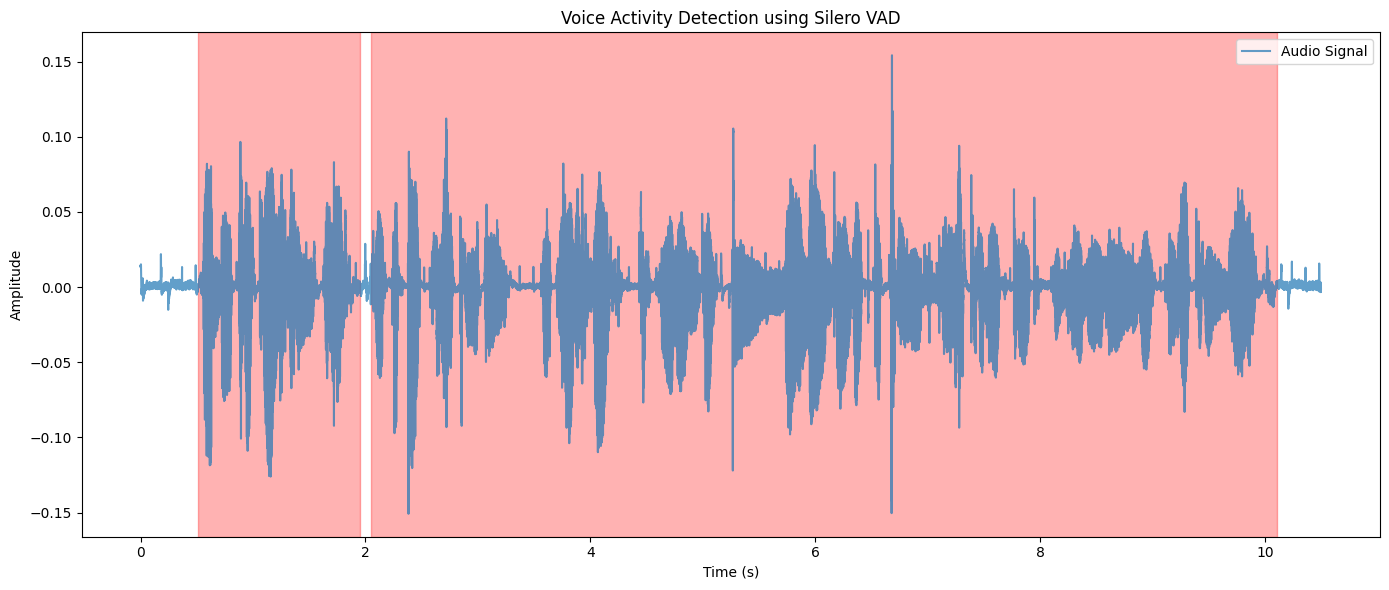

In [46]:
import torch
import torchaudio
import matplotlib.pyplot as plt

# Load the Silero VAD model from Torch Hub
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', trust_repo=True)
get_speech_timestamps = utils[0]  # Extracting only the function we need

# Load the audio file
wav, sr = torchaudio.load('test.wav')

# Get speech timestamps
vad_segments = get_speech_timestamps(wav, model, sampling_rate=sr)
print("Detected speech segments:", vad_segments)

# Create time axis for plotting
times = torch.arange(0, wav.shape[1]) / sr

# Plot the audio waveform
plt.figure(figsize=(14, 6))
plt.plot(times.numpy(), wav[0].numpy(), label="Audio Signal", alpha=0.7)

# Plot speech segments
for segment in vad_segments:
    start_time = segment['start'] / sr
    end_time = segment['end'] / sr
    plt.axvspan(start_time, end_time, color='red', alpha=0.3)

plt.title("Voice Activity Detection using Silero VAD")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


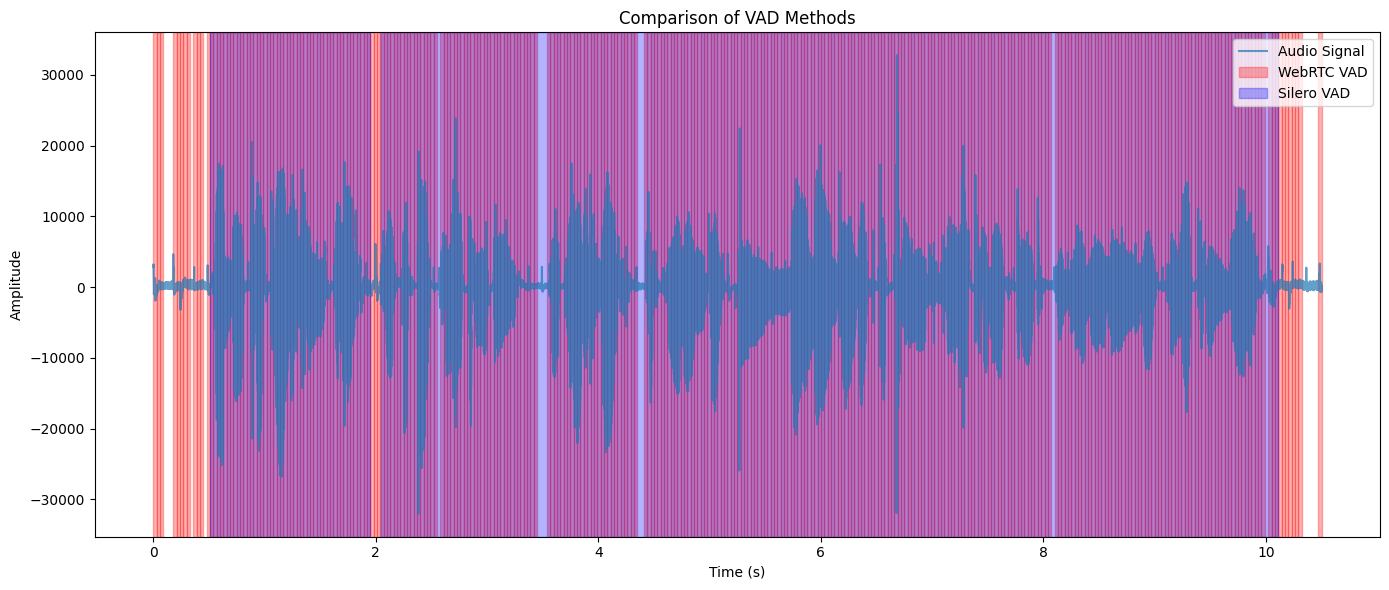

In [48]:
import webrtcvad
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pyannote.audio import Pipeline

# --- Load Audio ---
rate, audio = wavfile.read('test.wav')
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1).astype(np.int16)
audio = (audio / np.max(np.abs(audio)) * 32767).astype(np.int16)

# --- WebRTC VAD ---
def webrtc_vad(audio, rate, frame_duration=30, threshold=0.02):
    frame_length = int(rate * frame_duration / 1000)
    frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_length)]
    vad = webrtcvad.Vad(2)
    vad_flags = [vad.is_speech(frame.tobytes(), rate) for frame in frames if len(frame) == frame_length]
    return vad_flags

# --- Silero VAD ---
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', trust_repo=True)
get_speech_timestamps = utils[0]
wav_tensor, sr = torchaudio.load('test.wav')
silero_vad_segments = get_speech_timestamps(wav_tensor, model, sampling_rate=sr)


# --- Plotting ---
times = np.arange(len(audio)) / rate

plt.figure(figsize=(14, 6))
plt.plot(times, audio, label="Audio Signal", alpha=0.7)

# --- WebRTC VAD Plot ---
webrtc_flags = webrtc_vad(audio, rate)
for i, flag in enumerate(webrtc_flags):
    if flag:
        start_time = i * frame_duration / 1000
        end_time = (i + 1) * frame_duration / 1000
        plt.axvspan(start_time, end_time, color='red', alpha=0.3, label='WebRTC VAD' if i == 0 else "")

# --- Silero VAD Plot ---
for segment in silero_vad_segments:
    start_time = segment['start'] / sr
    end_time = segment['end'] / sr
    plt.axvspan(start_time, end_time, color='blue', alpha=0.3, label='Silero VAD' if segment == silero_vad_segments[0] else "")


plt.title("Comparison of VAD Methods")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

---
### Ground Truth Values of Voice Detection in upload audio file

In [51]:
import wave
import webrtcvad
import collections
import sys

def generate_voice_segments(wav_file_path, aggressiveness=3, frame_duration_ms=30):
    """
    Generate ground truth segments where voice is detected in a .wav file.

    Args:
        wav_file_path (str): Path to the .wav file.
        aggressiveness (int): VAD aggressiveness (0-3). Higher is more aggressive.
        frame_duration_ms (int): Duration of each audio frame in milliseconds (10, 20, or 30).

    Returns:
        list: List of tuples (start_time_ms, end_time_ms) where voice is detected.
    """
    # Validate frame duration
    if frame_duration_ms not in [10, 20, 30]:
        raise ValueError("frame_duration_ms must be 10, 20, or 30")

    # Initialize VAD
    vad = webrtcvad.Vad(aggressiveness)

    # Read the .wav file
    with wave.open(wav_file_path, 'rb') as wf:
        sample_rate = wf.getframerate()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        pcm_data = wf.readframes(wf.getnframes())

    # Validate audio format (webrtcvad requires 16-bit mono PCM)
    if sample_width != 2:
        raise ValueError("Sample width must be 2 (16-bit PCM)")
    if n_channels != 1:
        raise ValueError("Audio must be mono")

    # Calculate frame size in bytes
    frame_size_bytes = (sample_rate * frame_duration_ms * sample_width) // 1000

    # Split audio into frames
    frames = [
        pcm_data[i * frame_size_bytes : (i + 1) * frame_size_bytes]
        for i in range(len(pcm_data) // frame_size_bytes)
    ]

    # Convert frame times to milliseconds
    voice_segments = []
    voice_active = False
    start_time = 0

    for i, frame in enumerate(frames):
        time_ms = i * frame_duration_ms
        is_speech = vad.is_speech(frame, sample_rate)

        if is_speech and not voice_active:
            # Voice activity starts
            voice_active = True
            start_time = time_ms
        elif not is_speech and voice_active:
            # Voice activity ends
            voice_active = False
            end_time = time_ms
            voice_segments.append((start_time, end_time))

    # Add the last segment if voice is active at the end
    if voice_active:
        voice_segments.append((start_time, len(frames) * frame_duration_ms))

    return voice_segments


if __name__ == "__main__":
    wav_file = "test.wav"
    ground_truth = generate_voice_segments(wav_file)
    print("Ground truth voice segments (ms):", ground_truth)

Ground truth voice segments (ms): [(0, 90), (570, 1350), (1380, 1620), (1680, 1770), (1800, 1920), (2100, 2220), (2250, 2550), (2580, 2760), (2850, 3360), (3570, 4320), (4440, 4590), (4620, 5190), (5250, 6510), (6540, 7320), (7380, 7740), (7770, 8040), (8130, 9090), (9150, 9300), (9390, 9780), (10020, 10110)]


In [52]:
import numpy as np
import webrtcvad
import torch
import torchaudio
from scipy.io import wavfile
from scipy.signal import get_window
from scipy.fft import fft

def get_all_vad_predictions(wav_file_path):
    """
    Get voice activity detection predictions from all methods in ground truth format.

    Args:
        wav_file_path (str): Path to the .wav file

    Returns:
        dict: {
            'webrtc': [(start1, end1), (start2, end2), ...],
            'silero': [(start1, end1), (start2, end2), ...],
            'entropy': [(start1, end1), (start2, end2), ...],
            'zcr': [(start1, end1), (start2, end2), ...],
            'energy': [(start1, end1), (start2, end2), ...]
        }
    """
    # --- Load and Preprocess Audio ---
    rate, audio = wavfile.read(wav_file_path)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    audio = audio / np.max(np.abs(audio))

    # Convert to 16-bit PCM for WebRTC VAD
    audio_16bit = (audio * 32767).astype(np.int16)

    # ========================
    # WebRTC VAD Predictions
    # ========================
    def webrtc_vad_segments(audio, rate, frame_duration=30):
        frame_length = int(rate * frame_duration / 1000)
        frames = [audio[i:i+frame_length] for i in range(0, len(audio), frame_length)]
        vad = webrtcvad.Vad(2)  # Medium aggressiveness

        segments = []
        current_start = None

        for i, frame in enumerate(frames):
            if len(frame) != frame_length:
                continue

            is_speech = vad.is_speech(frame.tobytes(), rate)
            time = i * frame_duration / 1000  # Convert to seconds

            if is_speech and current_start is None:
                current_start = time
            elif not is_speech and current_start is not None:
                segments.append((current_start, time))
                current_start = None

        if current_start is not None:
            segments.append((current_start, len(frames) * frame_duration / 1000))

        return segments

    # ========================
    # Silero VAD Predictions
    # ========================
    def silero_vad_segments(wav_file_path):
        model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                                     model='silero_vad',
                                     trust_repo=True)
        get_speech_timestamps = utils[0]

        wav_tensor, sr = torchaudio.load(wav_file_path)
        silero_segments = get_speech_timestamps(wav_tensor, model, sampling_rate=sr)

        return [(seg['start']/sr, seg['end']/sr) for seg in silero_segments]

    # ========================
    # Spectral Entropy VAD
    # ========================
    def spectral_entropy(frame, eps=1e-8):
        spectrum = np.abs(fft(frame))[:len(frame)//2]
        psd = spectrum ** 2
        psd_norm = psd / (np.sum(psd) + eps)
        entropy = -np.sum(psd_norm * np.log2(psd_norm + eps))
        return entropy / np.log2(len(psd_norm))

    def entropy_vad_segments(audio, rate, window_duration=0.025, threshold=0.7):
        frame_length = int(rate * window_duration)
        num_frames = int(np.ceil(len(audio) / frame_length))
        window = get_window('hann', frame_length, fftbins=True)

        segments = []
        current_start = None

        for i in range(num_frames):
            start = i * frame_length
            end = start + frame_length
            frame = audio[start:end]
            if len(frame) < frame_length:
                frame = np.pad(frame, (0, frame_length - len(frame)))
            frame = frame * window
            entropy = spectral_entropy(frame)

            time = i * window_duration
            if entropy > threshold and current_start is None:
                current_start = time
            elif entropy <= threshold and current_start is not None:
                segments.append((current_start, time))
                current_start = None

        if current_start is not None:
            segments.append((current_start, num_frames * window_duration))

        return segments

    # ========================
    # ZCR VAD
    # ========================
    def zcr_vad_segments(audio, rate, window_duration=0.025, threshold=0.4):
        frame_length = int(rate * window_duration)
        num_frames = int(np.ceil(len(audio) / frame_length))

        segments = []
        current_start = None

        for i in range(num_frames):
            start = i * frame_length
            end = start + frame_length
            frame = audio[start:end]
            if len(frame) == 0:
                continue
            zcr = np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame))

            time = i * window_duration
            if zcr > threshold and current_start is None:
                current_start = time
            elif zcr <= threshold and current_start is not None:
                segments.append((current_start, time))
                current_start = None

        if current_start is not None:
            segments.append((current_start, num_frames * window_duration))

        return segments

    # ========================
    # Energy VAD
    # ========================
    def energy_vad_segments(audio, rate, window_duration=0.025, threshold=0.4):
        frame_length = int(rate * window_duration)
        num_frames = int(np.ceil(len(audio) / frame_length))

        segments = []
        current_start = None

        for i in range(num_frames):
            start = i * frame_length
            end = start + frame_length
            frame = audio[start:end]
            energy = np.sum(frame**2)

            time = i * window_duration
            if energy > threshold and current_start is None:
                current_start = time
            elif energy <= threshold and current_start is not None:
                segments.append((current_start, time))
                current_start = None

        if current_start is not None:
            segments.append((current_start, num_frames * window_duration))

        return segments

    # Run all VAD methods
    return {
        'webrtc': webrtc_vad_segments(audio_16bit, rate),
        'silero': silero_vad_segments(wav_file_path),
        'entropy': entropy_vad_segments(audio, rate),
        'zcr': zcr_vad_segments(audio, rate),
        'energy': energy_vad_segments(audio, rate)
    }

if __name__ == "__main__":
    predictions = get_all_vad_predictions("test.wav")
    for method, segments in predictions.items():
        print(f"{method.upper()} VAD segments:")
        for start, end in segments:
            print(f"  {start:.3f}s - {end:.3f}s")
        print()

Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


WEBRTC VAD segments:
  0.000s - 0.090s
  0.180s - 0.330s
  0.360s - 0.450s
  0.480s - 2.550s
  2.580s - 3.450s
  3.540s - 4.350s
  4.410s - 8.070s
  8.100s - 9.990s
  10.020s - 10.320s
  10.470s - 10.500s

SILERO VAD segments:
  0.514s - 1.950s
  2.050s - 10.110s

ENTROPY VAD segments:
  0.875s - 0.900s
  1.225s - 1.275s
  1.300s - 1.325s
  1.350s - 1.375s
  1.625s - 1.650s
  1.725s - 1.800s
  2.050s - 2.075s
  2.575s - 2.600s
  2.700s - 2.775s
  2.825s - 2.850s
  3.550s - 3.575s
  3.900s - 3.950s
  4.425s - 4.450s
  4.525s - 4.550s
  6.525s - 6.550s
  7.675s - 7.700s
  7.750s - 7.800s
  7.950s - 7.975s
  8.100s - 8.125s
  9.100s - 9.125s
  9.300s - 9.325s
  9.375s - 9.400s
  9.700s - 9.750s
  9.900s - 9.925s

ZCR VAD segments:
  0.875s - 0.900s
  1.225s - 1.375s
  1.625s - 1.800s
  2.675s - 2.775s
  3.875s - 3.950s
  7.250s - 7.300s
  7.775s - 7.800s
  7.950s - 7.975s
  9.225s - 9.325s
  9.700s - 9.925s

ENERGY VAD segments:
  0.000s - 0.025s
  0.175s - 0.200s
  0.225s - 0.250s
  0.55

---
### Comparing Voice Detection Models

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def compare_vad_methods(wav_file_path, ground_truth_ms):
    """
    Compare multiple VAD methods against ground truth and compute metrics.

    Args:
        wav_file_path: Path to audio file
        ground_truth_ms: Ground truth segments in milliseconds [(start,end), ...]

    Returns:
        dict: Evaluation metrics for each method
        dict: Predictions from all methods
    """
    # Convert ground truth to seconds for comparison
    ground_truth = [(start/1000, end/1000) for start, end in ground_truth_ms]
    total_truth_duration = sum(end-start for start,end in ground_truth)

    # Get predictions from all methods (from previous implementation)
    predictions = get_all_vad_predictions(wav_file_path)

    # Add ground truth to predictions for plotting
    predictions['ground_truth'] = ground_truth

    # Evaluation metrics storage
    metrics = defaultdict(dict)

    # Calculate metrics for each method
    for method, pred_segments in predictions.items():
        if method == 'ground_truth':
            continue

        # Convert predictions to binary frame-level (10ms frames)
        frame_size = 0.01  # 10ms evaluation resolution
        max_time = max([end for _,end in ground_truth] + [end for _,end in pred_segments])
        num_frames = int(np.ceil(max_time / frame_size))

        # Create binary arrays
        truth_array = np.zeros(num_frames)
        pred_array = np.zeros(num_frames)

        # Mark ground truth frames
        for start, end in ground_truth:
            start_frame = int(start / frame_size)
            end_frame = int(end / frame_size)
            truth_array[start_frame:end_frame] = 1

        # Mark predicted frames
        for start, end in pred_segments:
            start_frame = int(start / frame_size)
            end_frame = int(end / frame_size)
            pred_array[start_frame:end_frame] = 1

        # Calculate metrics
        tp = np.sum((truth_array == 1) & (pred_array == 1))
        fp = np.sum((truth_array == 0) & (pred_array == 1))
        fn = np.sum((truth_array == 1) & (pred_array == 0))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[method] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'total_detected': sum(end-start for start,end in pred_segments),
            'total_truth': total_truth_duration
        }

    return metrics, predictions

def plot_comparison(predictions, metrics):
    """Visualize VAD results comparison"""
    plt.figure(figsize=(14, 8))

    # Create time axis
    all_segments = [seg for method_segs in predictions.values() for seg in method_segs]
    max_time = max(end for _,end in all_segments)
    times = np.linspace(0, max_time, 1000)  # High-res time axis

    # Colors for each method
    colors = {
        'ground_truth': 'black',
        'webrtc': 'red',
        'silero': 'blue',
        'entropy': 'green',
        'zcr': 'purple',
        'energy': 'orange'
    }

    # Plot each method
    for method, segments in predictions.items():
        for start, end in segments:
            plt.axvspan(start, end, color=colors[method], alpha=0.3, label=method)

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("VAD Method Comparison\n" +
              "\n".join([f"{m}: F1={metrics[m]['f1']:.2f} (P={metrics[m]['precision']:.2f}, R={metrics[m]['recall']:.2f})"
                         for m in metrics]))
    plt.xlabel("Time (s)")
    plt.ylabel("Method")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    wav_file = "test.wav"

    # Get ground truth (your existing function)
    ground_truth_ms = generate_voice_segments(wav_file)

    # Compare all methods
    metrics, predictions = compare_vad_methods(wav_file, ground_truth_ms)

    # Print metrics
    print("Evaluation Metrics:")
    for method, vals in metrics.items():
        print(f"{method.upper():<8} F1: {vals['f1']:.3f} | Precision: {vals['precision']:.3f} | Recall: {vals['recall']:.3f}")
        print(f"           Detected: {vals['total_detected']:.2f}s / Truth: {vals['total_truth']:.2f}s")


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


Evaluation Metrics:
WEBRTC   F1: 0.901 | Precision: 0.819 | Recall: 1.000
           Detected: 9.96s / Truth: 8.16s
SILERO   F1: 0.913 | Precision: 0.848 | Recall: 0.989
           Detected: 9.50s / Truth: 8.16s
ENTROPY  F1: 0.107 | Precision: 0.600 | Recall: 0.059
           Detected: 0.80s / Truth: 8.16s
ZCR      F1: 0.147 | Precision: 0.698 | Recall: 0.082
           Detected: 0.95s / Truth: 8.16s
ENERGY   F1: 0.872 | Precision: 0.896 | Recall: 0.849
           Detected: 7.73s / Truth: 8.16s


---

## 🎯 Key Takeaways

- **Silero** performs the best overall with the **highest F1 score (0.913)**, making it a reliable choice for voice activity detection on this dataset.
- **WebRTC** achieves **perfect recall (1.000)**, meaning it detects all true speech segments, but it comes at the cost of slightly lower precision.
- **Energy-based VAD** shows solid performance and may serve as a **robust fallback option** with high precision (0.896).
- **Entropy** and **ZCR-based** methods significantly underperform in both F1 score and recall, making them **unreliable for accurate VAD tasks** on this audio.

---
END oF NOTEBOOK

---